<a href="https://colab.research.google.com/github/sugi-san/PAMA/blob/main/pama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

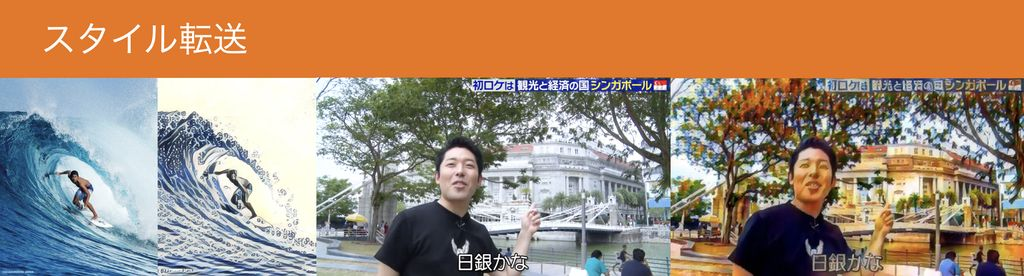

In [ ]:
#@title **1.セットアップ**

# githubからコードをコピー
! git clone https://github.com/sugi-san/PAMA.git
%cd PAMA

# 学習パラメータのダウンロード
! pip install --upgrade gdown
import gdown
# original
gdown.download('https://drive.google.com/uc?id=1rPB_qnelVVSad6CtadmhRFi0PMI_RKdy', 'original_PAMA.zip', quiet=False)
! unzip original_PAMA.zip
# consistency
gdown.download('https://drive.google.com/uc?id=1IrggOiutiZceJCrEb24cLnBjeA5I3N1D', 'PAMA_without_color.zip', quiet=False)
! unzip PAMA_without_color.zip
# color
gdown.download('https://drive.google.com/uc?id=1HXet2u_zk2QCVM_z5Llg2bcfvvndabtt', 'PAMA_1.5_color.zip', quiet=False)
! unzip PAMA_1.5_color.zip
# content
gdown.download('https://drive.google.com/uc?id=13m7Lb9xwfG_DVOesuG9PyxDHG4SwqlNt', 'PAMA_1.5_content.zip', quiet=False)
! unzip PAMA_1.5_content.zip


import os
import shutil

# downloadフォルダ作成
os.makedirs('download', exist_ok=True)

#学習済みパラメータの設定関数
def select_param(select):

    # checkpointsフォルダーリセット
    if os.path.isdir('checkpoints'):
        shutil.rmtree('checkpoints')

    if select == 'original':
      shutil.copytree('original_PAMA', 'checkpoints')

    if select == 'consistency':
      shutil.copytree('PAMA_without_color', 'checkpoints')  
      shutil.copy('original_PAMA/encoder.pth', 'checkpoints/encoder.pth')

    if select == 'color':
      shutil.copytree('PAMA_1.5_color', 'checkpoints')
      shutil.copy('original_PAMA/encoder.pth', 'checkpoints/encoder.pth')

    if select == 'content':
      shutil.copytree('PAMA_1.5_content', 'checkpoints')
      shutil.copy('original_PAMA/encoder.pth', 'checkpoints/encoder.pth')

    print('checkpoint is '+select)


# 画像連結関数
from PIL import Image
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def edit_pic(file1, file2):
    f1 = Image.open(file1)
    f2 = Image.open(file2)
    f1_resize = f1.resize((f2.width, f2.height))
    get_concat_h(f1_resize, f2).save('disp.jpg')

# ライブラリ・インポート
from function import *


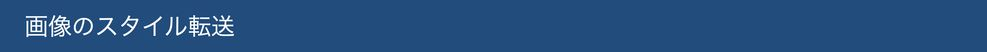

In [ ]:
#@title **2.コンテンツとスタイルの表示**
print('=== content ===')
display_pic('content')
print('=== style ===')
display_pic('style')

In [ ]:
#@title **3.画像のスタイル転送**

# 設定
checkpoint = 'color' #@param ["original", "consistency", "color", "content"] {allow-input: true}
content = '03.jpg'#@param {type:"string"}
style = '03.jpg'#@param {type:"string"}

# 学習済みパラメータの選択
select_param(checkpoint)

# スタイル転送
! python main.py eval --content content/$content --style style/$style

# 変換前後の画像連結
edit_pic('content/'+content, 'ics.jpg')

# 連結画像表示
from google.colab.patches import cv2_imshow
import cv2 
img_cv=cv2.imread('disp.jpg')
cv2_imshow(img_cv)

In [ ]:
#@title **4.画像のダウンロード**
import os
import shutil
from google.colab import files

content_name = os.path.splitext(content)
style_name = os.path.splitext(style)
file_name = 'download/'+content_name[0]+'_'+style_name[0]+'_'+checkpoint+'.jpg'
shutil.copy('disp.jpg', file_name)
files.download(file_name)

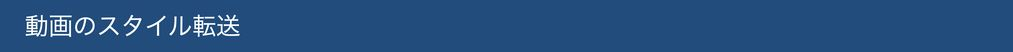

In [ ]:
#@title **5.動画とスタイルの表示**

# --- 動画表示 ---
print('=== video ===')
reset_folder('pic')
files = sorted(os.listdir('video'))
for file in files:
  save_frame(file)
display_movie('pic', files)

# --- 画像表示 ---
print('=== style ===')
display_pic('style')

In [ ]:
#@title **6.動画のスタイル転送**
#@markdown ・videoは音声付きとして下さい

# 学習済みパラメータの選択
checkpoint = 'content' #@param ["original", "consistency", "color", "content"] {allow-input: true}
select_param(checkpoint)

# --- 動画を静止画にバラす ---
video = '01.mp4' #@param {type:"string"}
video_file = 'video/'+video

import os
import shutil
import cv2

# flamesフォルダーリセット
if os.path.isdir('images'):
    shutil.rmtree('images')
os.makedirs('images', exist_ok=True)
 
def video_2_images(video_file= video_file,   # ビデオの指定
                   image_dir='images/', 
                   image_file='%s.jpg'):  

    # Initial setting
    i = 0
    interval = 1
    length = 3000  # 最大フレーム数
    
    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)  # fps取得

    while(cap.isOpened()):
        flag, frame = cap.read()  
        if flag == False:  
                break
        if i == length*interval:
                break
        if i % interval == 0:    
           cv2.imwrite(image_dir+image_file % str(int(i/interval)).zfill(6), frame)
        i += 1 
    cap.release()
    return fps, i, interval
 
fps, i, interval = video_2_images()
#print('fps = ', fps)
#print('flames = ', i)
#print('interval = ', interval)


# --- 動画のスタイル転送 ---
# style_movieフォルダーリセット
if os.path.isdir('style_movie'):
    shutil.rmtree('style_movie')
os.makedirs('style_movie', exist_ok=True)

# 指定したstyleをstyle_movieフォルダへコピー
import shutil
style = '04.jpg'#@param {type:"string"}
shutil.copy('style/'+style, 'style_movie/'+style)

# icsフォルダーリセット
if os.path.isdir('ics'):
    shutil.rmtree('ics')
os.makedirs('ics', exist_ok=True)

# 静止画をスタイル転送
! python main.py eval --run_folder True --content images/ --style style_movie/

# 静止画から動画の作成
print('making movie...')
fps_n = fps/interval
!ffmpeg -y -r $fps_n -i ics/%06d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error out.mp4

# 音声の抽出＆付加
print('preparation for sound...')
! ffmpeg -y -i $video_file -loglevel error sound.mp3
! ffmpeg -y -i out.mp4 -i sound.mp3 -loglevel error output.mp4

In [ ]:
#@title **7.動画の再生**
from IPython.display import HTML
from base64 import b64encode

mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="70%" height="70%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title **8.動画のダウンロード**
import os
import shutil
from google.colab import files

content_name = os.path.splitext(video)
style_name = os.path.splitext(style)
file_name = 'download/'+content_name[0]+'_'+style_name[0]+'_'+checkpoint+'.mp4'
shutil.copy('output.mp4', file_name)
files.download(file_name)

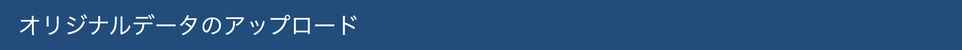

In [ ]:
#@title **9.データアップロード**
#@markdown ・selectで、コンテンツ（content）、スタイル（style）、動画（video）を選択して下さい\
#@markdown ・動画はHD以下、30秒以内にして下さい
import os
import shutil
from google.colab import files
import cv2

select = 'video' #@param ["content", "style", "video"]

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
for file in uploaded:
    shutil.move(file, select+'/'+file)

###【備考】
**・ブラウザは、必ずGoogle Chromeを使用して下さい。**

**・checkpointの４つの選択肢の内容**\
１）color : styleを強調\
２）content : contentを強調\
３）original : styleとcontentを半々に強調\
４）styleとcontentを半々に弱く

           
**・動作がおかしくなった場合の対応**\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

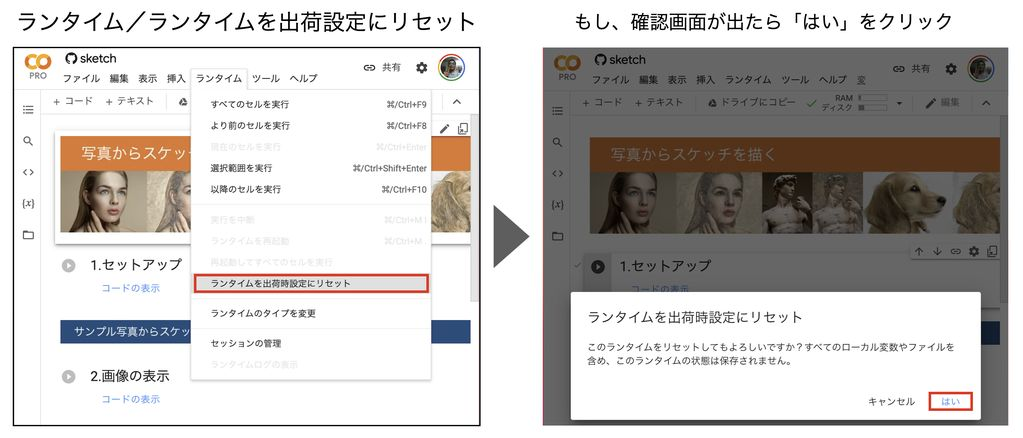